## Questions I want to answer: 
1. Which stock fluctuates more? 
1. What is the correlation between different stocks?
1. What was the daily return of the stock on average?
1. Which stock has less risk?
1. Which stock has more risk?

In [126]:
#import dataset from yahoo
from pandas_datareader.data import DataReader

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [127]:
help(DataReader)

Help on function DataReader in module pandas_datareader.data:

DataReader(name, data_source=None, start=None, end=None, retry_count=3, pause=0.1, session=None, api_key=None)
    Imports data from a number of online sources.
    
    Currently supports Google Finance, St. Louis FED (FRED),
    and Kenneth French's data library, among others.
    
    Parameters
    ----------
    name : str or list of strs
        the name of the dataset. Some data sources (IEX, fred) will
        accept a list of names.
    data_source: {str, None}
        the data source ("iex", "fred", "ff")
    start : string, int, date, datetime, Timestamp
        left boundary for range (defaults to 1/1/2010)
    end : string, int, date, datetime, Timestamp
        right boundary for range (defaults to today)
    retry_count : {int, 3}
        Number of times to retry query request.
    pause : {numeric, 0.001}
        Time, in seconds, to pause between consecutive queries of chunks. If
        single value given 

In [128]:
# tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']



In [136]:
end = datetime.now()  #end date
# year, month, day
start = datetime(year=end.year - 4, month=end.month, day=end.day)


#get me stock data of google for year 2019
df = DataReader('GOOG', 'yahoo',start=start, end=end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-10,789.380005,775.869995,777.710022,785.940002,1174900,785.940002
2016-10-11,792.280029,780.580017,786.659973,783.070007,1372500,783.070007
2016-10-12,788.130005,782.059998,783.760010,786.140015,937400,786.140015
2016-10-13,781.219971,773.000000,781.219971,778.190002,1365300,778.190002
2016-10-14,783.950012,776.000000,781.650024,778.530029,852500,778.530029


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2016-10-10 to 2020-10-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1008 non-null   float64
 1   Low        1008 non-null   float64
 2   Open       1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Volume     1008 non-null   int64  
 5   Adj Close  1008 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 55.1 KB


In [138]:
df.describe

<bound method NDFrame.describe of                    High          Low         Open        Close   Volume  \
Date                                                                      
2016-10-10   789.380005   775.869995   777.710022   785.940002  1174900   
2016-10-11   792.280029   780.580017   786.659973   783.070007  1372500   
2016-10-12   788.130005   782.059998   783.760010   786.140015   937400   
2016-10-13   781.219971   773.000000   781.219971   778.190002  1365300   
2016-10-14   783.950012   776.000000   781.650024   778.530029   852500   
...                 ...          ...          ...          ...      ...   
2020-10-05  1488.209961  1464.270020  1466.209961  1486.020020  1113300   
2020-10-06  1486.760010  1448.589966  1475.579956  1453.439941  1245400   
2020-10-07  1468.959961  1436.000000  1464.290039  1460.290039  1746200   
2020-10-08  1490.000000  1465.089966  1465.089966  1485.930054  1187800   
2020-10-09  1516.520020  1489.449951  1494.699951  1515.219971  14

# feature engineering 

In [139]:
def generate_features(df):
    '''
    Generate features based on historical price and performance
    '''
    df = pd.DataFrame(df)
    #shift index by 1 to take values of previous days and assign to current values
    
    #compute shifted return
    df['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    #moving avg of daily returns over the past week
    df['moving_avg_5'] = df['return_1'].rolling(window=5).mean() #windows exclude weekends
    #moving avg of daily returns over the past month
    df['moving_avg_30'] = df['return_1'].rolling(window=21).mean()
    #moving avg of daily returns over the past year
    df['moving_avg_360'] = df['return_1'].rolling(window=252).mean()
    

    df = df.dropna(axis=0)
    
    print(len(df['moving_avg_360']))
    print(df['moving_avg_360'].count())
    return df


df = generate_features(df)

755
755


# Split the data into train and test

In [141]:
# divide data into train and test data

#importing sklearn libraries
from sklearn.model_selection import train_test_split

#feature cols is all fields except close
feature_cols = list(df.drop(['Close'], axis=1).columns)

start_train = datetime(2016, 10, 10, 0, 0) #oct 10 2016
end_train = datetime(2020, 5, 31, 0, 0) #may 31 2020

#split data into train and test dataset
data_train = df[start_train:end_train]
data_test = df[end_train:]

#get x_train, y_train, x_test, y_test
x_train = data_train[feature_cols]
y_train = data_train['Close']
x_test =  data_test[feature_cols]
y_test = data_test['Close']


# P.S :  Get more training data
print(x_train.shape) 
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(662, 9)
(662,)
(93, 9)
(93,)


# Scale the data

In [142]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(x_train) #fit scaler only based on train set

#rescale both sets using the trained scaler
x_scaled_train = scaler.transform(x_train)
x_scaled_test = scaler.transform(x_test)

## Linear Regression

In [143]:
#close is the target column
#all remaining fields are featured columns

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

#We will use SGD-based linear regression model

param_grid = {
    "alpha": [3e-06, 1e-5, 3e-5],
    "eta0": [0.01, 0.03, 0.1],
}


lr = SGDRegressor(penalty='l2',max_iter=3000)
# print(lr.n_iter_)
grid_search = GridSearchCV(lr, param_grid, cv=5,
                                scoring='neg_mean_absolute_error')

grid_search.fit(x_scaled_train, y_train)
   

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=3000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [3e-06, 1e-05, 3e-05],
                         'eta0': [0.01, 0.03, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbo

In [144]:
#select the best linear regression model and make prediction of testing samples
grid_search.best_params_

{'alpha': 3e-05, 'eta0': 0.1}

In [145]:
lr_best = grid_search.best_estimator_
y_pred = lr_best.predict(x_scaled_test)

In [146]:
#calculate the MSE and r2 value
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

1.10227248225335
0.9997501760041358


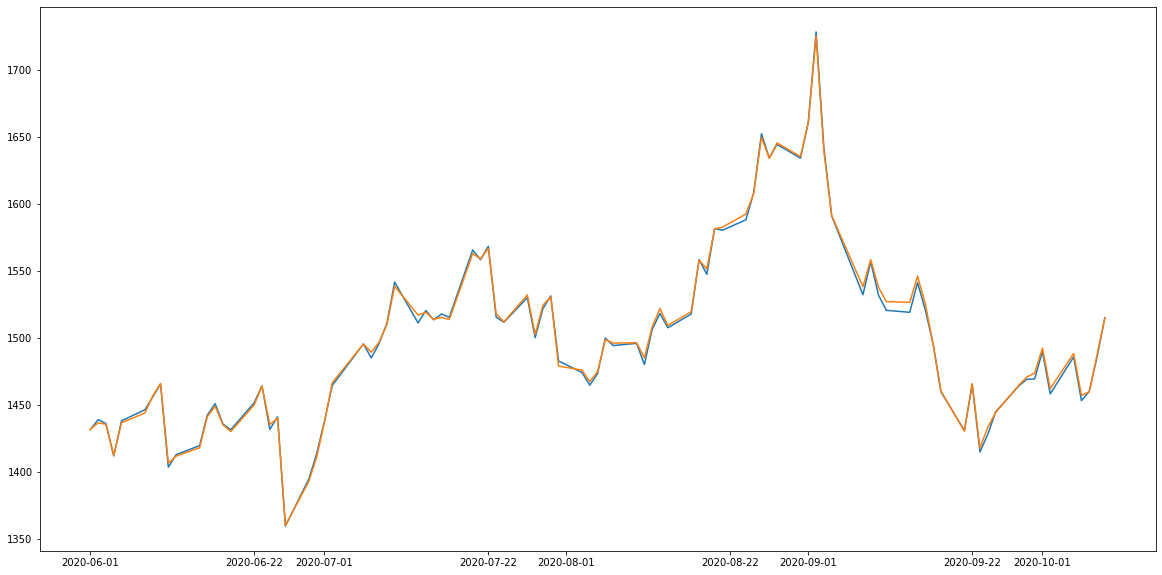

In [118]:
plt.figure(figsize=(20,10))
plt.plot(x_test.index, y_test, '-',
        x_test.index, y_pred, '-'
        )

## Random Forest Regression

In [147]:
from sklearn.ensemble import RandomForestRegressor

#we use the unscaled data because feature scale disparity won't affect it
param_grid = {
  "max_depth": [30, 50],
   "min_samples_split": [3, 5, 10],
}
rf = RandomForestRegressor(n_estimators=1000)
grid_search = GridSearchCV(rf, param_grid, cv=5,
                                 scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=1000, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [148]:
#select the best rf model and make prediction of testing samples
grid_search.best_params_

{'max_depth': 50, 'min_samples_split': 3}

In [149]:
rf_best = grid_search.best_estimator_
y_pred = rf_best.predict(x_test)
print(y_pred[:5])
print(y_test[:5])

[1430.96407357 1436.79575175 1435.7418008  1417.22564861 1431.43541301]
Date
2020-06-01    1431.819946
2020-06-02    1439.219971
2020-06-03    1436.380005
2020-06-04    1412.180054
2020-06-05    1438.390015
Name: Close, dtype: float64


In [150]:
#calculate the MSE and r2 value
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))print(r2_score(y_test, y_pred))

SyntaxError: invalid syntax (<ipython-input-150-f267218bebd6>, line 3)

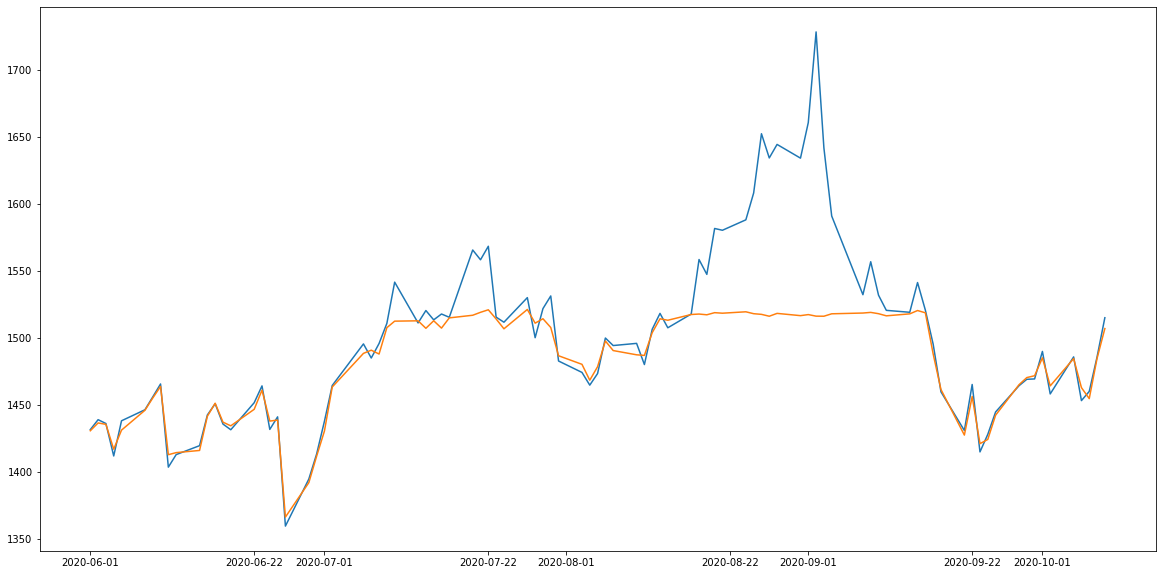

In [151]:
plt.figure(figsize=(20,10))
plt.plot(x_test.index, y_test, '-',
        x_test.index, y_pred, '-',
        )

## Support Vector Regression (SVR)

In [152]:
from sklearn.svm import SVR

param_grid = {
    "C": [1000, 3000, 10000],
    "epsilon": [0.00001, 0.00003, 0.0001],
}

#instantiate SVR
svr = SVR(kernel='linear')

grid_search = GridSearchCV(svr, param_grid, cv=5,
                                  scoring='neg_mean_absolute_error')

#we use scaled data since SVR doesn't work well with unscaled
grid_search.fit(x_scaled_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='linear',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1000, 3000, 10000],
                         'epsilon': [1e-05, 3e-05, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [153]:
#select the best svr model and make prediction of testing samples
grid_search.best_params_

{'C': 1000, 'epsilon': 0.0001}

In [154]:
#get the best svr 
svr_best = grid_search.best_estimator_
y_pred = svr_best.predict(x_scaled_test)
print(y_pred[:5])
print(y_test[:5])

[1431.81986877 1439.21975658 1436.37982906 1412.17982255 1438.38983883]
Date
2020-06-01    1431.819946
2020-06-02    1439.219971
2020-06-03    1436.380005
2020-06-04    1412.180054
2020-06-05    1438.390015
Name: Close, dtype: float64


In [155]:
#calculate the MSE and r2 value
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

6.148312157226857e-08
0.00019712700892312335
0.9999999999860651


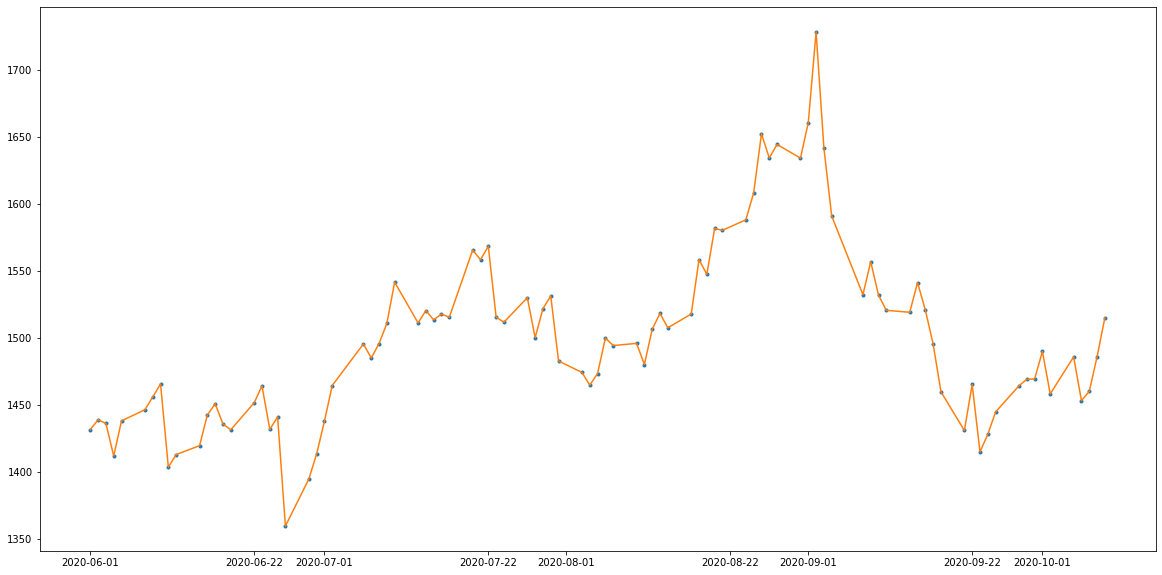

In [156]:
#plot
plt.figure(figsize=(20,10))
plt.plot(x_test.index, y_test, '.',
        x_test.index, y_pred, '-'
        )
